In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

%matplotlib inline
pd.set_option('display.max_columns', 100)

In [2]:
def one_hot(lst, num_class=4) :
    return np.eye(num_class)[lst]

In [3]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    label = activity[["acc_id", "label"]]
    
    activity = activity[activity["label"] != "empty"]
    activity = activity.drop("label", axis=1)
    label = label[label["label"] != "empty"]
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    label = label.sort_values("acc_id")
    
    label_lst = sorted(list(set([tuple(x) for x in label.values])))
    label = pd.DataFrame(label_lst, columns = ["acc_id", "label"])
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    num_values = len(activity1.values[0])
    
    activity = np.concatenate([activity1.values.reshape([-1, 1, num_values]), activity2.values.reshape([-1, 1, num_values]), 
                               activity3.values.reshape([-1, 1, num_values]), activity4.values.reshape([-1, 1, num_values]),
                               activity5.values.reshape([-1, 1, num_values]), activity6.values.reshape([-1, 1, num_values]),
                               activity7.values.reshape([-1, 1, num_values]), activity8.values.reshape([-1, 1, num_values])], axis=1)
    
    label_dic = {"week":0 , "month" :1, "2month":2, "retained":3}

    label2 = label.sort_values(by="acc_id")
    label2["label"] = label2["label"].map(lambda x : label_dic[x])
    
    total_lst = activity
    label_dic = label2.label.tolist()
    total_label = one_hot(label_dic)
    
    return total_lst, total_label

 <br></br><br></br><br></br>

In [4]:
total_lst, total_label = making_data("OnlyExpanded.csv")

In [5]:
idx1 = len(total_lst)//5 *4

training_lst = np.array(total_lst[:idx1])
valid_lst = np.array(total_lst[idx1:])

training_label = np.array(total_label[:idx1])
valid_label = np.array(total_label[idx1:])

In [6]:
print(np.array(total_lst).shape)
print(np.array(total_label).shape)

(100000, 8, 38)
(100000, 4)


<br></br><br></br><br></br>

# Model

In [7]:
class CNN() :
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        
    def convolution(self, input_X, kernel_size, width, num_filter, activation=True) :
        conv = tf.layers.conv2d(input_X, filters=num_filter, kernel_size=[kernel_size, width], strides=1)
        
        if activation :
            norm = tf.contrib.layers.layer_norm(conv)
            relu = tf.nn.relu(norm)
        
            return relu
        return conv
        
    def build(self, batch_size, height, width, depth, is_embedding, emb_width, num_filter, is_fc, fc_num_unit, fc_activation, cost_function, output_dim) :
        with tf.variable_scope(self.name) :
            
            ## Setting ##
            self.batch_size = batch_size
            self.height = height
            self.width = width
            self.depth = depth
            self.is_embedding = is_embedding
            self.emb_width = emb_width
            self.num_filter = num_filter
            self.is_fc = is_fc
            self.fc_num_unit = fc_num_unit
            self.fc_activation = fc_activation
            self.output_dim = output_dim
            
            self.X = tf.placeholder(tf.float32, [None, self.height, self.width])
            self.Y = tf.placeholder(tf.float32, [None, self.output_dim])
            self.learning_rate =  tf.placeholder(tf.float32)
            self.training = tf.placeholder(tf.bool)
            #############
            
            
            ## Embedding ##
            if self.is_embedding :
                W_emb = tf.Variable(tf.random_normal([self.width, self.emb_width]))
                self.X = tf.concat(self.X, tf.matmul(self.X, W_emb), axis=2)
                
            reshaped_X = tf.reshape(self.X, [-1, self.height, self.width, self.depth])
            ###############
            
            
            ## Convolution ##
            conv1 = self.convolution(reshaped_X, 1, self.width, self.num_filter)
            conv1 = self.convolution(conv1, 4, 1, self.num_filter*2)
            conv1 = self.convolution(conv1, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv1.get_shape().as_list()
            conv1 = tf.reshape(conv1, [-1, height*width*depth])
            
            conv2 = self.convolution(reshaped_X, 2, self.width, self.num_filter)
            conv2 = self.convolution(conv2, 4, 1, self.num_filter*2)
            conv2 = self.convolution(conv2, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv2.get_shape().as_list()
            conv2 = tf.reshape(conv2, [-1, height*width*depth])
            
            conv3 = self.convolution(reshaped_X, 3, self.width, self.num_filter)
            conv3 = self.convolution(conv3, 4, 1, self.num_filter*2)
            conv3 = self.convolution(conv3, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv3.get_shape().as_list()
            conv3 = tf.reshape(conv3, [-1, height*width*depth])
            
            conv4 = self.convolution(reshaped_X, 4, self.width, self.num_filter)
            conv4 = self.convolution(conv4, 4, 1, self.num_filter*2)
            conv4 = self.convolution(conv4, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv4.get_shape().as_list()
            conv4 = tf.reshape(conv4, [-1, height*width*depth])
            
            conv5 = self.convolution(reshaped_X, 5, self.width, self.num_filter)
            conv5 = self.convolution(conv5, 4, 1, self.num_filter*2)
            conv5 = self.convolution(conv5, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv5.get_shape().as_list()
            conv5 = tf.reshape(conv5, [-1, height*width*depth])
            
            conv6 = self.convolution(reshaped_X, 6, self.width, self.num_filter)
            conv6 = self.convolution(conv6, 3, 1, self.num_filter*2)
            conv6 = self.convolution(conv6, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv6.get_shape().as_list()
            conv6 = tf.reshape(conv6, [-1, height*width*depth])
            
            conv7 = self.convolution(reshaped_X, 7, self.width, self.num_filter)
            conv7 = self.convolution(conv7, 2, 1, self.num_filter*2)
            conv7 = self.convolution(conv7, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv7.get_shape().as_list()
            conv7 = tf.reshape(conv7, [-1, height*width*depth])
            
            conv8 = self.convolution(reshaped_X, 8, self.width, self.num_filter)
            conv8 = self.convolution(conv8, 1, 1, self.num_filter*2)
            conv8 = self.convolution(conv8, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv8.get_shape().as_list()
            conv8 = tf.reshape(conv8, [-1, height*width*depth])
            #################
            
            ## Classifier ##
            conv_result = tf.concat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8], axis=1)
            
            if is_fc : 
                dense= tf.layers.dense(conv_result, self.fc_num_unit)
                norm = tf.contrib.layers.layer_norm(dense)
                relu = tf.nn.relu(norm)
                self.logit = tf.layers.dense(norm, 4)
            else :
                self.logit = tf.layers.dense(conv_result, 4)
                
            self.softmax = tf.nn.softmax(self.logit)
            ################
            
            
            ## Learning ##
            if cost_function == "f1" :
                self.numerator = tf.reduce_sum(self.softmax*self.Y)
                self.denominator = tf.reduce_sum(self.softmax*self.Y + self.Y)
                self.cost = -2 * self.numerator / self.denominator
                
            else :
                self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logit, labels=self.Y))

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)
            with tf.control_dependencies(update_ops):
                self.optimizer = tf.train.AdadeltaOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
            self.prediction = tf.equal(tf.argmax(self.logit, 1), tf.argmax(self.Y, 1))     
            self.accuracy = tf.reduce_mean(tf.cast(self.prediction, tf.float32))    
            ##############
        
        
    def train(self, X_input, Y_input, learning_rate, training=True):
        feed_dict = {self.X: X_input, self.Y: Y_input, self.learning_rate: learning_rate, self.training: training}
        _, cost = self.sess.run([self.optimizer, self.cost], feed_dict=feed_dict)
        
        return _, cost
    
    def predict(self, X_input, training=False):
        feed_dict = {self.X: X_input, self.training: training}
        result = self.sess.run([self.logit], feed_dict=feed_dict)
            
        return result
    
    def evaluate(self, X_input, Y_input):
        size = X_input.shape[0]
            
        total_loss = 0
        total_acc = 0
            
        for idx in range(0, size, self.batch_size):
            X_batch = X_input[idx:idx + batch_size]
            Y_batch = Y_input[idx:idx + batch_size]
            feed_dict = {self.X: X_batch, self.Y: Y_batch, self.training: False}
                
            loss = self.cost
            accuracy = self.accuracy
                
            step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed_dict)
                
            total_loss += step_loss * X_batch.shape[0]
            total_acc += step_acc * X_batch.shape[0]
            
        total_loss /= size
        total_acc /= size
            
        return total_loss, total_acc

In [8]:
tf.reset_default_graph() 

<br></br><br></br><br></br> 

In [10]:
learning_rate1 = 0.02
learning_rate2 = 0.01
learning_rate3 = 0.005
learning_rate4 = 0.001

total_epoch = 80
batch_size = 500
input_dim = np.array(total_lst).shape[1]

In [11]:
idx = 0
is_pass = False
model_lst = []

for is_embedding in [False, True] :
    for emb_width in [64,128] :
        if not is_pass :
            is_pass = True
            continue
            
        for num_filter in [16, 32] :
            for is_fc in [False, True] :
                for cost in ["accuracy"] :
                    print(idx) 
                    sess = tf.Session()
                    model = CNN(sess, "model{}".format(idx))
                    model.build(500, 8, 38, 1, False, emb_width, num_filter, is_fc, 128, tf.nn.relu, cost, 4)
                    sess.run(tf.global_variables_initializer())

                    model_lst.append(model)
                    idx +=1
            
tl_ta_vl_va_lst = [[[],[],[],[]]]*len(model_lst)
print("Ready!")

0
1
2
3
4
5
6
7
8
9
10
11
Ready!


In [12]:
print('Learning Started!')
print("")

# train my model
for epoch in range(total_epoch):
    avg_cost = [0]*len(model_lst)
    total_batch = int(len(training_lst) / batch_size)
    idx = 0
    
    if epoch == 0 :
        learning_rate = learning_rate1
    elif epoch == 10 :
        learning_rate = learning_rate2
    elif epoch == 20 :
        learning_rate = learning_rate3
    elif epoch == 80 :
        learning_rate = learning_rate4

    for i in range(total_batch):
        batch_xs, batch_ys = training_lst[idx:idx+batch_size],training_label[idx:idx+batch_size]
        
        for model_num, model in enumerate(model_lst) :
            _, c = model.train(batch_xs, batch_ys, learning_rate)
            avg_cost[model_num] += c / total_batch
        
        idx += batch_size
        if i%10 == 0 :
            print("log :", i)
            
    #train/valid cost & acc
    print("***epoch*** : ", epoch)
    for model_num, model in enumerate(model_lst) :
        train_cost, train_acc = model.evaluate(training_lst, training_label)
        valid_cost, valid_acc = model.evaluate(valid_lst, valid_label)

        tl_ta_vl_va_lst[model_num][0].append(train_cost)
        tl_ta_vl_va_lst[model_num][1].append(train_acc)
        tl_ta_vl_va_lst[model_num][2].append(valid_cost)
        tl_ta_vl_va_lst[model_num][3].append(valid_acc)

        print("-- train {:.5f}({:.1f}%), valid{:.5f}({:.1f}%)".format(train_cost, train_acc*100, valid_cost, valid_acc*100))
    
    for model in model_lst :
        print('Accuracy:', model.evaluate(valid_lst, valid_label)[1])
    print(" ")

print("")
print('Learning Finished!')

Learning Started!

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  0
-- train 1.35683(33.8%), valid1.35739(33.7%)
-- train 1.30405(39.9%), valid1.30124(40.1%)
-- train 1.15017(52.9%), valid1.14686(53.0%)
-- train 1.18132(50.5%), valid1.17847(50.5%)
-- train 1.29839(35.2%), valid1.29792(35.2%)
-- train 1.33045(35.0%), valid1.32804(35.3%)
-- train 1.17667(50.2%), valid1.17896(50.2%)
-- train 1.14669(52.7%), valid1.15072(52.7%)
-- train 1.54776(26.9%), valid1.54645(27.1%)
-- train 1.25002(41.8%), valid1.24679(42.2%)
-- train 1.24393(42.5%), valid1.23952(42.8%)
-- train 1.16553(53.4%), valid1.16210(53.8%)
Accuracy: 0.337000001222
Accuracy: 0.400699998438
Accuracy: 0.529649998993
Accuracy: 0.505199998617
Accuracy: 0.352350000292
Accuracy: 0.353150000423
Accuracy: 0.502049997449
Accuracy: 0.526750001311
Accuracy: 0.271250000596
Accuracy: 0.422400001436
Accuracy: 0.428250000626


log : 130
log : 140
log : 150
***epoch*** :  8
-- train 0.95593(60.5%), valid0.95423(60.8%)
-- train 0.90602(62.3%), valid0.90251(62.5%)
-- train 0.87446(63.1%), valid0.87240(63.2%)
-- train 0.85485(63.9%), valid0.85390(63.8%)
-- train 0.95479(60.5%), valid0.95064(60.5%)
-- train 0.90984(61.9%), valid0.90706(62.0%)
-- train 0.87821(63.4%), valid0.87922(63.6%)
-- train 0.84324(63.6%), valid0.84538(63.5%)
-- train 0.94623(60.7%), valid0.94591(61.0%)
-- train 0.93805(60.5%), valid0.93559(60.6%)
-- train 0.88437(62.1%), valid0.88297(62.1%)
-- train 0.84362(64.1%), valid0.84213(64.1%)
Accuracy: 0.608249996603
Accuracy: 0.62499999851
Accuracy: 0.631550002098
Accuracy: 0.637550000846
Accuracy: 0.605350001156
Accuracy: 0.619999997318
Accuracy: 0.635599994659
Accuracy: 0.635000002384
Accuracy: 0.609599997103
Accuracy: 0.60625000298
Accuracy: 0.621000002325
Accuracy: 0.64129999876
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log :

-- train 0.81554(64.9%), valid0.81745(64.9%)
-- train 0.90757(62.2%), valid0.90474(62.3%)
-- train 0.86999(63.3%), valid0.86782(63.4%)
-- train 0.84193(64.4%), valid0.84436(64.5%)
-- train 0.81036(64.9%), valid0.81452(65.0%)
-- train 0.89832(62.4%), valid0.89860(62.4%)
-- train 0.88745(62.3%), valid0.88644(62.2%)
-- train 0.84232(64.2%), valid0.84335(64.1%)
-- train 0.81195(65.4%), valid0.81301(65.0%)
Accuracy: 0.625799995661
Accuracy: 0.638800002635
Accuracy: 0.641500000656
Accuracy: 0.648649993539
Accuracy: 0.623000001907
Accuracy: 0.634399999678
Accuracy: 0.645299999416
Accuracy: 0.649699999392
Accuracy: 0.623799999058
Accuracy: 0.622250004113
Accuracy: 0.641049998999
Accuracy: 0.650499996543
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  17
-- train 0.90756(62.6%), valid0.90571(62.7%)
-- train 0.86019(63.7%), valid0.85832(64.0%)
-- train 0.83510(64.4%), valid0.8348

-- train 0.82708(64.9%), valid0.83052(64.8%)
-- train 0.79667(65.5%), valid0.80236(65.4%)
-- train 0.88061(63.3%), valid0.88137(63.5%)
-- train 0.86668(63.2%), valid0.86678(62.9%)
-- train 0.82623(64.6%), valid0.82838(64.4%)
-- train 0.79835(65.9%), valid0.80116(65.6%)
Accuracy: 0.630350002646
Accuracy: 0.642549996078
Accuracy: 0.645849999785
Accuracy: 0.654899993539
Accuracy: 0.626200000942
Accuracy: 0.639150004089
Accuracy: 0.647949996591
Accuracy: 0.65380000025
Accuracy: 0.635300004482
Accuracy: 0.628650002182
Accuracy: 0.644250003994
Accuracy: 0.656150002778
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  25
-- train 0.89204(63.0%), valid0.89034(63.0%)
-- train 0.84636(64.0%), valid0.84544(64.3%)
-- train 0.82150(64.9%), valid0.82224(64.6%)
-- train 0.79925(65.5%), valid0.80312(65.5%)
-- train 0.88890(62.7%), valid0.88663(62.8%)
-- train 0.85224(63.8%), valid0.85049

-- train 0.85504(64.4%), valid0.85574(64.1%)
-- train 0.81723(64.9%), valid0.82007(64.6%)
-- train 0.79031(66.1%), valid0.79429(65.7%)
Accuracy: 0.632849998772
Accuracy: 0.644650000334
Accuracy: 0.648300001025
Accuracy: 0.65909999907
Accuracy: 0.630250000954
Accuracy: 0.641349999607
Accuracy: 0.650199997425
Accuracy: 0.65910000205
Accuracy: 0.636950002611
Accuracy: 0.64130000174
Accuracy: 0.645950002968
Accuracy: 0.657450000942
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  33
-- train 0.88168(63.2%), valid0.88003(63.3%)
-- train 0.83748(64.2%), valid0.83705(64.5%)
-- train 0.81275(65.2%), valid0.81422(64.9%)
-- train 0.79098(65.9%), valid0.79603(65.9%)
-- train 0.87852(63.0%), valid0.87659(63.0%)
-- train 0.84300(64.0%), valid0.84149(64.2%)
-- train 0.81748(65.1%), valid0.82156(65.0%)
-- train 0.78764(66.1%), valid0.79429(66.0%)
-- train 0.86928(63.5%), valid0.87036(6

Accuracy: 0.63599999994
Accuracy: 0.646849998832
Accuracy: 0.650850002468
Accuracy: 0.661399999261
Accuracy: 0.632999998331
Accuracy: 0.644249996543
Accuracy: 0.65190000087
Accuracy: 0.662400001287
Accuracy: 0.638800002635
Accuracy: 0.645299999416
Accuracy: 0.648450002074
Accuracy: 0.660650002956
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  41
-- train 0.87271(63.4%), valid0.87106(63.6%)
-- train 0.82988(64.5%), valid0.82990(64.7%)
-- train 0.80519(65.4%), valid0.80736(65.1%)
-- train 0.78384(66.2%), valid0.79003(66.2%)
-- train 0.86949(63.3%), valid0.86790(63.3%)
-- train 0.83506(64.3%), valid0.83388(64.5%)
-- train 0.81016(65.3%), valid0.81473(65.2%)
-- train 0.78058(66.4%), valid0.78816(66.3%)
-- train 0.86073(63.7%), valid0.86216(63.9%)
-- train 0.84413(64.8%), valid0.84546(64.6%)
-- train 0.80856(65.1%), valid0.81222(64.9%)
-- train 0.78235(66.4%), valid0.78755(

Accuracy: 0.653500004113
Accuracy: 0.663799999654
Accuracy: 0.640300004184
Accuracy: 0.649150002003
Accuracy: 0.649499998987
Accuracy: 0.662700001895
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  49
-- train 0.86475(63.7%), valid0.86320(63.9%)
-- train 0.82329(64.8%), valid0.82376(64.9%)
-- train 0.79841(65.6%), valid0.80132(65.2%)
-- train 0.77748(66.5%), valid0.78479(66.4%)
-- train 0.86147(63.5%), valid0.86016(63.5%)
-- train 0.82798(64.7%), valid0.82714(64.9%)
-- train 0.80362(65.6%), valid0.80874(65.4%)
-- train 0.77429(66.6%), valid0.78281(66.4%)
-- train 0.85326(63.8%), valid0.85501(64.1%)
-- train 0.83577(65.0%), valid0.83768(64.9%)
-- train 0.80194(65.2%), valid0.80638(65.0%)
-- train 0.77605(66.6%), valid0.78222(66.3%)
Accuracy: 0.638599999249
Accuracy: 0.649450002611
Accuracy: 0.651849998534
Accuracy: 0.663749998808
Accuracy: 0.635350003839
Accuracy: 0.6487

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  57
-- train 0.85753(63.9%), valid0.85610(64.0%)
-- train 0.81728(64.9%), valid0.81823(65.1%)
-- train 0.79239(65.9%), valid0.79603(65.5%)
-- train 0.77177(66.8%), valid0.78011(66.6%)
-- train 0.85437(63.8%), valid0.85334(63.8%)
-- train 0.82171(64.9%), valid0.82121(65.0%)
-- train 0.79779(65.8%), valid0.80347(65.6%)
-- train 0.76858(66.9%), valid0.77798(66.5%)
-- train 0.84651(64.1%), valid0.84857(64.2%)
-- train 0.82834(65.2%), valid0.83082(65.1%)
-- train 0.79597(65.6%), valid0.80122(65.3%)
-- train 0.77022(66.9%), valid0.77739(66.5%)
Accuracy: 0.640399999917
Accuracy: 0.651049995422
Accuracy: 0.654600000381
Accuracy: 0.666050001979
Accuracy: 0.637500007451
Accuracy: 0.650150002539
Accuracy: 0.65624999702
Accuracy: 0.665449999273
Accuracy: 0.642250002921
Accuracy: 0.651250003278
Accuracy: 0.653150004148
Accuracy: 0.6654000

log : 150
***epoch*** :  65
-- train 0.85103(64.1%), valid0.84972(64.3%)
-- train 0.81175(65.3%), valid0.81317(65.5%)
-- train 0.78702(66.1%), valid0.79142(65.8%)
-- train 0.76651(67.0%), valid0.77584(66.8%)
-- train 0.84789(64.0%), valid0.84709(63.9%)
-- train 0.81597(65.0%), valid0.81582(65.2%)
-- train 0.79250(66.1%), valid0.79875(65.9%)
-- train 0.76345(67.1%), valid0.77381(66.7%)
-- train 0.84051(64.2%), valid0.84287(64.3%)
-- train 0.82188(65.4%), valid0.82489(65.4%)
-- train 0.79056(65.9%), valid0.79656(65.5%)
-- train 0.76485(67.1%), valid0.77306(66.8%)
Accuracy: 0.643299998343
Accuracy: 0.65474999994
Accuracy: 0.657650007308
Accuracy: 0.668099994957
Accuracy: 0.639200000465
Accuracy: 0.651650004089
Accuracy: 0.658849997818
Accuracy: 0.666649998724
Accuracy: 0.64319999963
Accuracy: 0.653599998355
Accuracy: 0.654700000584
Accuracy: 0.668250000477
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log

-- train 0.76173(67.2%), valid0.77215(67.0%)
-- train 0.84199(64.3%), valid0.84144(64.2%)
-- train 0.81069(65.3%), valid0.81092(65.4%)
-- train 0.78763(66.2%), valid0.79445(66.0%)
-- train 0.75877(67.2%), valid0.77010(66.9%)
-- train 0.83511(64.4%), valid0.83775(64.5%)
-- train 0.81603(65.6%), valid0.81958(65.5%)
-- train 0.78561(66.0%), valid0.79236(65.6%)
-- train 0.75989(67.3%), valid0.76908(67.0%)
Accuracy: 0.644000002742
Accuracy: 0.655500003695
Accuracy: 0.659549999237
Accuracy: 0.669600000978
Accuracy: 0.641900002956
Accuracy: 0.653599999845
Accuracy: 0.659950001538
Accuracy: 0.668649999797
Accuracy: 0.644599999487
Accuracy: 0.655499999225
Accuracy: 0.655600005388
Accuracy: 0.67025000006
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  74
-- train 0.84436(64.3%), valid0.84324(64.4%)
-- train 0.80596(65.4%), valid0.80790(65.6%)
-- train 0.78144(66.2%), valid0.78666

 <br></br><br></br><br></br> 

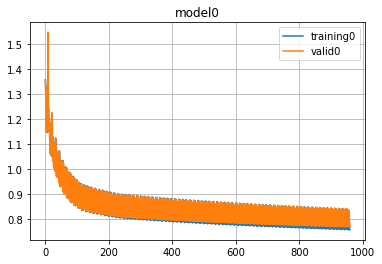

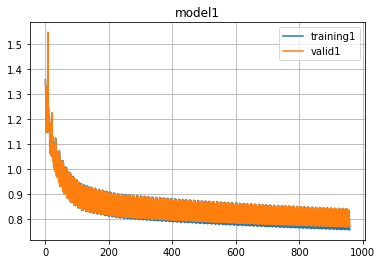

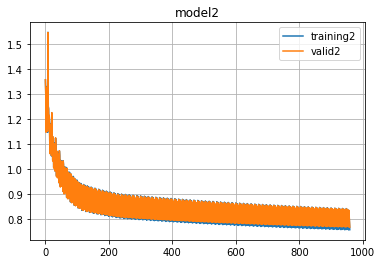

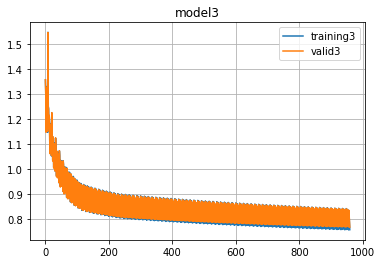

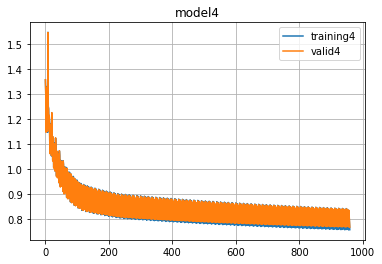

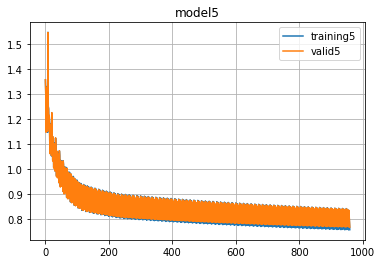

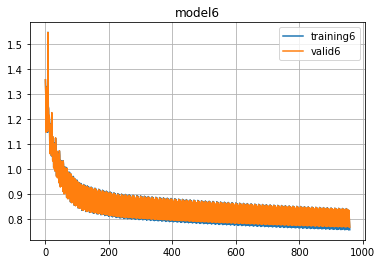

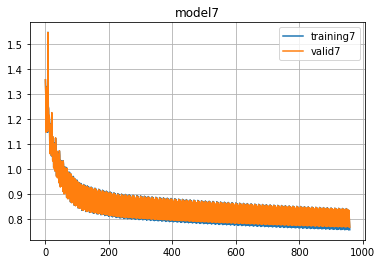

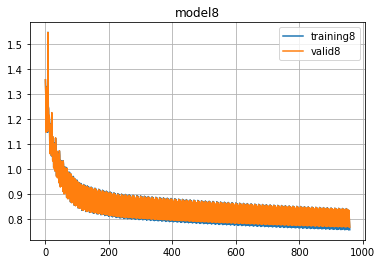

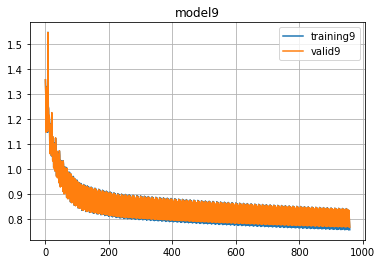

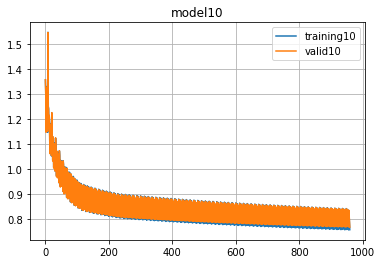

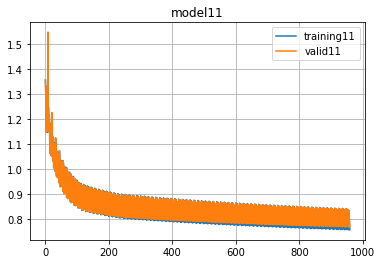

In [13]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][2], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

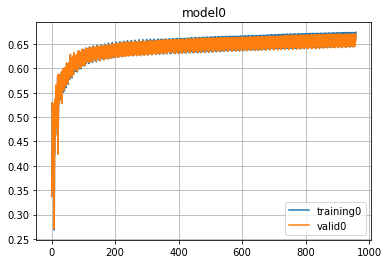

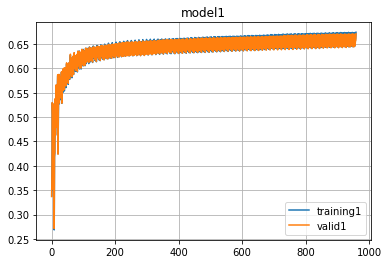

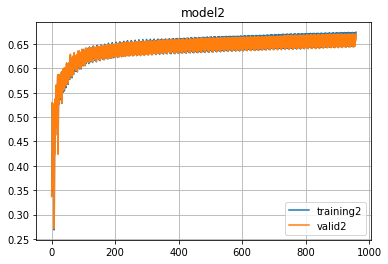

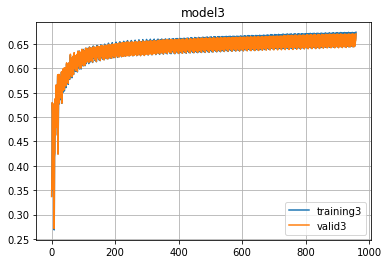

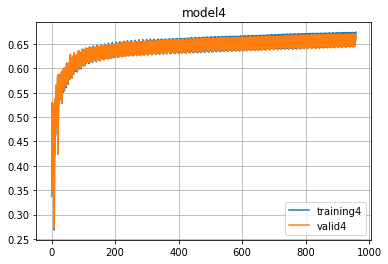

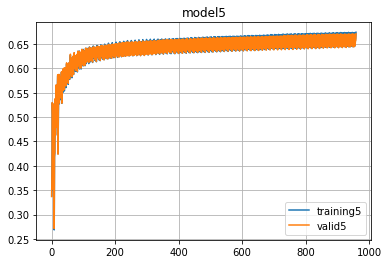

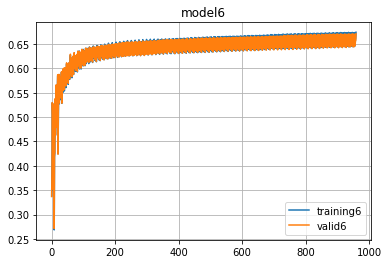

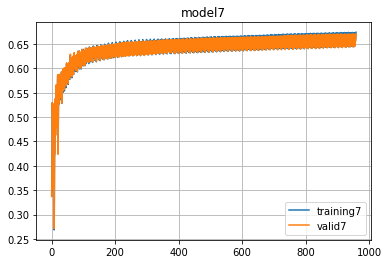

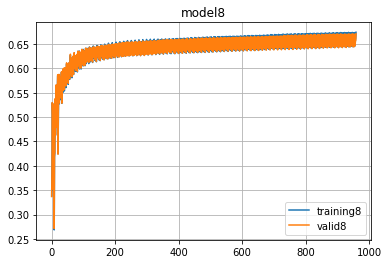

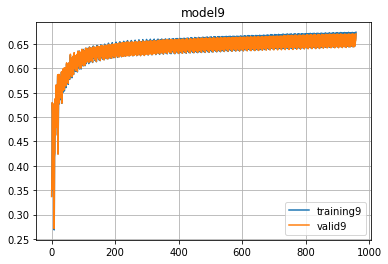

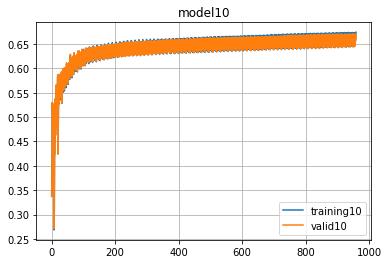

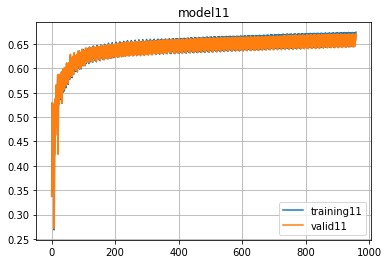

In [14]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][3], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

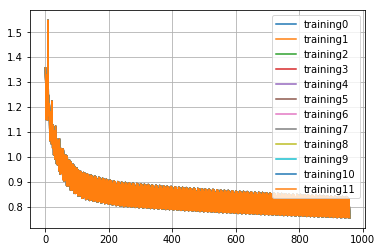

In [15]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

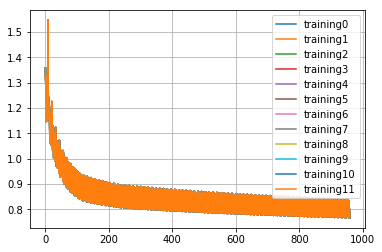

In [16]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][2], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

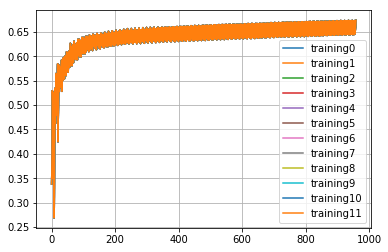

In [17]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

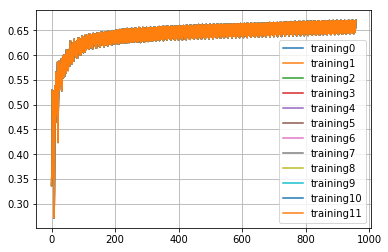

In [18]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][3], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

 <br></br><br></br><br></br>  

In [ ]:
#tf.reset_default_graph() 

In [364]:
saver = tf.train.Saver()

for idx, model in enumerate(model_lst) :
    saver.save(model.sess, './model/MLP_default_model_{}'.format(idx))

print("Saved!")

'./advanced_RNN/original_user_vector/original'

<br></br><br></br><br></br>

# Test

In [50]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    
    activity = activity[activity["label"] == "empty"]
    activity = activity.drop("label", axis=1)
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    label = activity["acc_id"].values
    num_values = len(activity1.values[0])
    
    activity = np.concatenate([activity1.values.reshape([-1, 1, num_values]), activity2.values.reshape([-1, 1, num_values]), 
                               activity3.values.reshape([-1, 1, num_values]), activity4.values.reshape([-1, 1, num_values]),
                               activity5.values.reshape([-1, 1, num_values]), activity6.values.reshape([-1, 1, num_values]),
                               activity7.values.reshape([-1, 1, num_values]), activity8.values.reshape([-1, 1, num_values])], axis=1)

    total_lst = activity
    return total_lst, label

In [51]:
test_data, test_acc_id = making_data("OnlyExpanded.csv")

In [52]:
print(test_data.shape)

(40000, 8, 38)


<br></br><br></br><br></br> 

# Predict

In [53]:
result = []
for model in model_lst :
    result.append(np.argmax(model.predict(test_data), axis=2)) 
    
result = list(map(lambda x : x.tolist()[0], result))
for r_lst in result :
    print("week: {}, month: {}, 2month: {}, retained: {}".format(r_lst.count(0), r_lst.count(1), r_lst.count(2), r_lst.count(3)))

week: 10156, month: 6714, 2month: 12836, retained: 10294
week: 10771, month: 5096, 2month: 13577, retained: 10556
week: 10411, month: 5777, 2month: 13900, retained: 9912
week: 10306, month: 5374, 2month: 13932, retained: 10388
week: 10832, month: 5526, 2month: 13789, retained: 9853
week: 11039, month: 5680, 2month: 12884, retained: 10397
week: 11278, month: 5435, 2month: 13439, retained: 9848
week: 10196, month: 6988, 2month: 12783, retained: 10033
week: 11023, month: 5661, 2month: 13198, retained: 10118
week: 11464, month: 5032, 2month: 12712, retained: 10792
week: 10626, month: 5415, 2month: 14015, retained: 9944
week: 11079, month: 5920, 2month: 12338, retained: 10663


In [ ]:
label_df = pd.DataFrame(sorted(list(set(list(test_acc_id))))).rename(columns = {0 : "acc_id"})
result_df = pd.DataFrame(result).T

In [ ]:
result_df2 = pd.concat([label_df, result_df], axis=1)
result_df2.head()